# Прогнозирование ДТП клиента каршеринга

Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту. Для этого нужно создать модель предсказания ДТП.

Краткое описание таблиц
- collisions — общая информация о ДТП. 
- parties — информация об участниках ДТП. 
- vehicles — информация о пострадавших машинах.

**План работ:**
- Изучений файлов с данными
- EDA основных данных
- Разработка моделей
- Тестирование лучшей модели
- Общий вывод по модели


## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install phik 

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
!pip install scikit-learn==1.2.2

     |████████████████████████████████| 9.6 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [3]:
# основные библиотеки
import pandas as pd
import numpy as np

from sqlalchemy import create_engine 

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    GridSearchCV, train_test_split)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
                            roc_curve, precision_score, recall_score, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

torch.manual_seed(1234)


In [4]:
# параметры для коннекта к базе
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

In [6]:
%%time

query = '''
SELECT *
FROM vehicles AS ve
JOIN parties AS par ON (ve.case_id = par.case_id) AND (ve.party_number = par.party_number)
JOIN collisions AS col ON ve.case_id = col.case_id

WHERE EXTRACT(YEAR FROM collision_date::date) = 2012 AND col.COLLISION_DAMAGE NOT LIKE '%%scratch%%' AND par.party_type LIKE '%%car%%'

'''

big_df = pd.read_sql_query(query, con=engine)
big_df.head()

CPU times: user 1.13 s, sys: 149 ms, total: 1.28 s
Wall time: 12 s


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,id,case_id,party_number,party_type,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,1328327,5456705,1,sedan,manual,5.0,2409910,5456705,1,car,...,unknown,unknown,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-18,20:10:00
1,1320375,5448917,1,sedan,manual,0.0,2395544,5448917,1,car,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-16,15:45:00
2,1338907,5467315,1,coupe,manual,10.0,2429686,5467315,1,car,...,vehicle code violation,dui,hit object,fixed object,dry,normal,dark with no street lights,none,2012-01-11,21:00:00
3,1339530,5467934,1,sedan,auto,0.0,2430834,5467934,1,car,...,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,2012-01-13,14:05:00
4,1340418,5468825,2,sedan,manual,1.0,2432591,5468825,2,car,...,other than driver,other than driver (or pedestrian),None,other object,dry,normal,daylight,functioning,2012-01-27,08:00:00


In [7]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   vehicle_type                 56248 non-null  object 
 4   vehicle_transmission         55389 non-null  object 
 5   vehicle_age                  54554 non-null  float64
 6   id                           56248 non-null  int64  
 7   case_id                      56248 non-null  object 
 8   party_number                 56248 non-null  int64  
 9   party_type                   56248 non-null  object 
 10  at_fault                     56248 non-null  int64  
 11  insurance_premium            55701 non-null  float64
 12  party_sobriety               55376 non-null  object 
 13  party_drug_physi

In [8]:
# %%time

# query = '''
# SELECT *
# FROM collisions AS col
# JOIN parties AS par ON (col.case_id = par.case_id) 
# JOIN vehicles as ve ON col.case_id = ve.case_id

# WHERE EXTRACT(YEAR FROM collision_date::date) = 2012 AND col.COLLISION_DAMAGE NOT LIKE '%%scratch%%' AND par.party_type LIKE '%%car%%'

# '''

# big_df = pd.read_sql_query(query, con=engine)
# big_df.head()



In [9]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   vehicle_type                 56248 non-null  object 
 4   vehicle_transmission         55389 non-null  object 
 5   vehicle_age                  54554 non-null  float64
 6   id                           56248 non-null  int64  
 7   case_id                      56248 non-null  object 
 8   party_number                 56248 non-null  int64  
 9   party_type                   56248 non-null  object 
 10  at_fault                     56248 non-null  int64  
 11  insurance_premium            55701 non-null  float64
 12  party_sobriety               55376 non-null  object 
 13  party_drug_physi

## Проведите первичное исследование таблиц

In [10]:
# Кол-во строк в таблице vehicles
query = '''
SELECT count(*)
FROM vehicles
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,1021234


In [11]:
# кол-во уникальных строк в таблице vehicles
query = '''
SELECT COUNT(DISTINCT(case_id))
FROM vehicles
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,792642


In [12]:
# Кол-во строк в таблице collisions
query = '''
SELECT count(*)
FROM collisions
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,1400000


In [13]:
# кол-во уникальных строк
query = '''
SELECT COUNT(DISTINCT(case_id))
FROM collisions
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,1400000


In [14]:
# кол-во уникальных строк
query = '''
SELECT count(*)
FROM parties
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,2752408


In [15]:
# кол-во уникальных строк в таблице parties
uery = '''
SELECT COUNT(DISTINCT(case_id))
FROM parties
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,count
0,2752408


**Вывод:** В 3 таблицах сильно отличается кол-во строчек. Так же видно что в таблице отсутствует фиксация уникальный id, поэтому возможно большое кол-во дубликатов. В дальнейшем стоит их удалить.

##  Проведите статистический анализ факторов ДТП

In [16]:
# Кол-во ДТП по месяцам
query = '''
SELECT DISTINCT(EXTRACT(MONTH FROM collision_date::date)), COUNT(*)
FROM collisions
GROUP BY EXTRACT(MONTH FROM collision_date::date)
'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()

,extract,count
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316


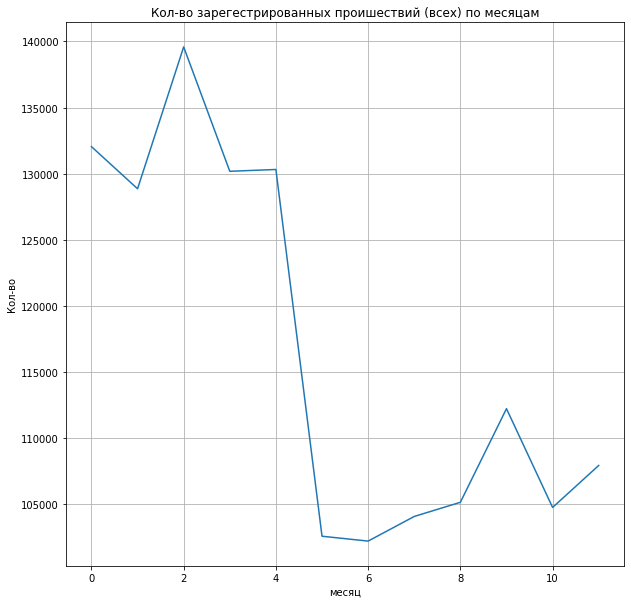

In [17]:
plt.figure(figsize=(10,10))
plt.plot(simple_df['count'])

plt.title('Кол-во зарегестрированных проишествий (всех) по месяцам')
plt.xlabel('месяц')
plt.ylabel('Кол-во')
plt.grid()
plt.show()

**Вывод:** Кол-во зафиксированных ДТП имеет большой разброс. Чаще всего аварии происходят с 1 по 4 месяц, в то время как в остальное время их практически нет. Вохможно это особенность предоставленных данных.

Необходимо провести исследование:
- Изучить кол-во проишествий в месяц для типа участника car
- Посмотреть кол-во серёзных ДТП по группам
- Изучить кол-во проишествий в месяц в зависимости от виновности участника ДТП
- Изучить какие типы кузова, типы КПП, возраст автомобиля (отдельными таблицами) чаще всего попадали в ДТП по месяцам
- Посмотреть зависимость трезвости участника ДТП от времени (24 часа) проишествия
- Посмотреть зависимость физического состояния участника ДТП от времени (24 часа) проишествия

In [20]:
# Изучить кол-во проишествий в месяц для типа участника car

query = '''
SELECT EXTRACT(MONTH FROM collision_date::date), COUNT(*)
FROM collisions AS col

JOIN parties as part ON col.case_id = part.case_id

WHERE part.party_type = 'car'

GROUP BY EXTRACT(MONTH FROM collision_date::date)

'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()


,extract,count
0,1.0,231071
1,2.0,226709
2,3.0,246541
3,4.0,229655
4,5.0,229668


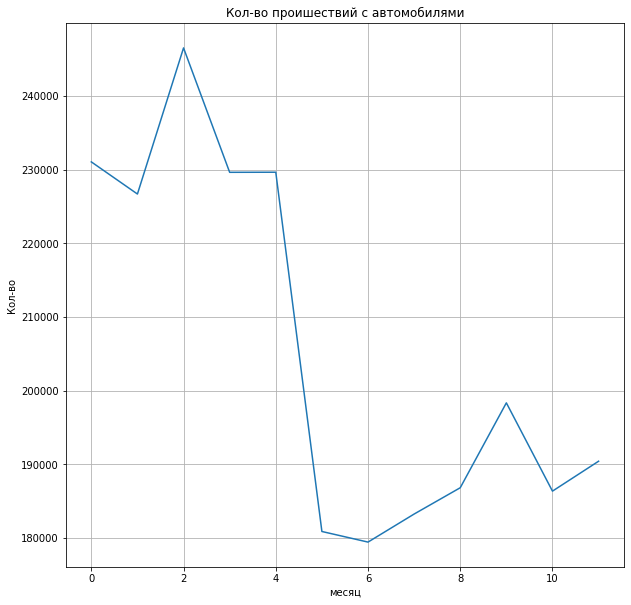

In [21]:
plt.figure(figsize=(10,10))
plt.plot(simple_df['count'])

plt.title('Кол-во проишествий с автомобилями')
plt.xlabel('месяц')
plt.ylabel('Кол-во')
plt.grid()
plt.show()

In [22]:
# Посмотреть зависимость трезвости участника ДТП от времени (24 часа) проишествия

query = '''
SELECT DISTINCT(COLLISION_DAMAGE), COUNT(COLLISION_DAMAGE)
FROM collisions
GROUP BY COLLISION_DAMAGE

'''

simple_df = pd.read_sql_query(query, con=engine)
simple_df.head()



,collision_damage,count
0,fatal,10793
1,middle damage,166583
2,scratch,346106
3,severe damage,30747
4,small damage,845771


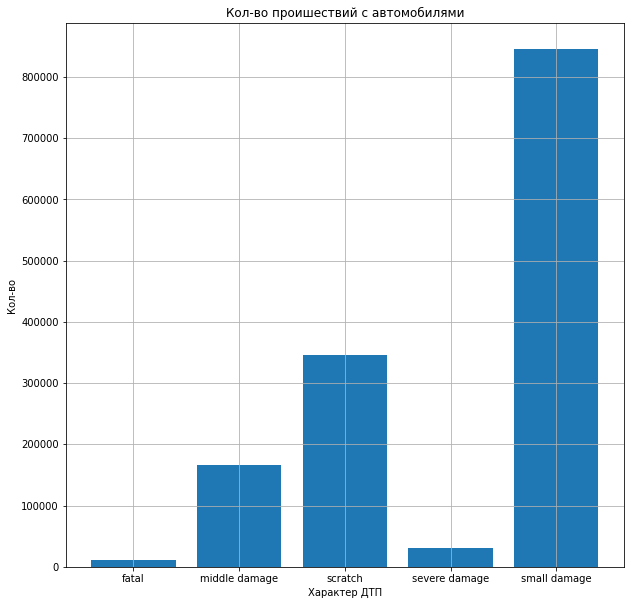

In [23]:
plt.figure(figsize=(10,10))
plt.bar(simple_df['collision_damage'], simple_df['count'])

plt.title('Кол-во проишествий с автомобилями')
plt.xlabel('Характер ДТП')
plt.ylabel('Кол-во')
plt.grid()
plt.show()

**Вывод:** Большинство аварий попадают в категорию "small damage", фактор "scratch" не учитываем по условию заказчика. Динамика проишествий с "car" идентична динамике зарегестрированных ДТП всего, следовательно в базе скорее всего преобладает информация по данному типу транспортного средства.

## Создайте модель для оценки водительского риска

In [24]:
# т.к. задаче предсказать попадание машины в ДТП, не будут учитываться факторы,
# которые уже являются результатом произошедшего ДТП 

columns = [
    'vehicle_type',
    'vehicle_transmission',
    'vehicle_age', #3 колонки основные параметры автомобиля
    'cellphone_in_use', #один из факторов возможного ДТП
    'party_drug_physical', #состояние водителя
    'party_sobriety', #состояние водителя 
    'at_fault', #целевой параметр
    'distance', #протяженность маршрута
    'direction', #направление
    'lighting', #освещение как корилирующий фактр времени
    'road_condition_1', #состояние дороги 
    'road_surface', #покрытие дороги
    'pcf_violation_category', # корреляция с сотоянием человека
    'location_type', # тип дороги
    'weather_1', # погода
    'intersection', #коррлирующий признак с типом дороги
    'county_location',
    'county_city_location' #последние 2 колонки будут указывать на риск аварии в городе или вне города
 
]

In [25]:
big_df_data = big_df[columns]

In [26]:
big_df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_type            56248 non-null  object 
 1   vehicle_transmission    55389 non-null  object 
 2   vehicle_age             54554 non-null  float64
 3   cellphone_in_use        51777 non-null  float64
 4   party_drug_physical     2857 non-null   object 
 5   party_sobriety          55376 non-null  object 
 6   at_fault                56248 non-null  int64  
 7   distance                56248 non-null  float64
 8   direction               43230 non-null  object 
 9   lighting                56094 non-null  object 
 10  road_condition_1        55999 non-null  object 
 11  road_surface            55900 non-null  object 
 12  pcf_violation_category  55482 non-null  object 
 13  location_type           25932 non-null  object 
 14  weather_1               56080 non-null

In [27]:
big_df_data.head()

,vehicle_type,vehicle_transmission,vehicle_age,cellphone_in_use,party_drug_physical,party_sobriety,at_fault,distance,direction,lighting,road_condition_1,road_surface,pcf_violation_category,location_type,weather_1,intersection,county_location,county_city_location
0,sedan,manual,5.0,0.0,None,had not been drinking,0,500.0,south,dark with no street lights,normal,dry,unknown,ramp,clear,0.0,san bernardino,3616
1,sedan,manual,0.0,0.0,None,had not been drinking,1,1325.0,west,daylight,normal,dry,speeding,highway,clear,0.0,san bernardino,3607
2,coupe,manual,10.0,NaN,None,"had been drinking, under influence",1,0.0,west,dark with no street lights,normal,dry,dui,highway,clear,0.0,shasta,4500
3,sedan,auto,0.0,0.0,None,had not been drinking,1,4752.0,south,daylight,normal,dry,improper turning,highway,clear,0.0,riverside,3300
4,sedan,manual,1.0,0.0,None,None,0,6.0,south,daylight,normal,dry,other than driver (or pedestrian),None,clear,0.0,sacramento,3404


### Создадим варинат обучения моделей 1. Заполним пропуски медианой и значением unknow

In [28]:
# сделае копию
data_unknow = big_df_data.copy()

In [29]:
data_unknow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_type            56248 non-null  object 
 1   vehicle_transmission    55389 non-null  object 
 2   vehicle_age             54554 non-null  float64
 3   cellphone_in_use        51777 non-null  float64
 4   party_drug_physical     2857 non-null   object 
 5   party_sobriety          55376 non-null  object 
 6   at_fault                56248 non-null  int64  
 7   distance                56248 non-null  float64
 8   direction               43230 non-null  object 
 9   lighting                56094 non-null  object 
 10  road_condition_1        55999 non-null  object 
 11  road_surface            55900 non-null  object 
 12  pcf_violation_category  55482 non-null  object 
 13  location_type           25932 non-null  object 
 14  weather_1               56080 non-null

In [30]:
data_unknow.duplicated().sum()

1339

In [31]:
# удалим дубликаты
data_unknow = data_unknow.drop_duplicates()

In [32]:
# колонки численных признаков
num_col = data_unknow.select_dtypes(include=['int', 'float']).columns.tolist()

# колонки категориальных признаков
cat_cols = data_unknow.select_dtypes(include=['object']).columns.tolist()


In [33]:
num_col, cat_cols

(['vehicle_age', 'cellphone_in_use', 'at_fault', 'distance', 'intersection'],
 ['vehicle_type',
  'vehicle_transmission',
  'party_drug_physical',
  'party_sobriety',
  'direction',
  'lighting',
  'road_condition_1',
  'road_surface',
  'pcf_violation_category',
  'location_type',
  'weather_1',
  'county_location',
  'county_city_location'])

In [34]:
num_col.remove('intersection') # это бинарный признак
cat_cols.append('intersection')

num_col.remove('cellphone_in_use') # это бинарный признак
cat_cols.append('cellphone_in_use')

num_col.remove('at_fault') # это целоевое значение

cat_cols.remove('county_city_location') #это значение координат
num_col.append('county_city_location')


In [35]:
data_unknow.head()

,vehicle_type,vehicle_transmission,vehicle_age,cellphone_in_use,party_drug_physical,party_sobriety,at_fault,distance,direction,lighting,road_condition_1,road_surface,pcf_violation_category,location_type,weather_1,intersection,county_location,county_city_location
0,sedan,manual,5.0,0.0,None,had not been drinking,0,500.0,south,dark with no street lights,normal,dry,unknown,ramp,clear,0.0,san bernardino,3616
1,sedan,manual,0.0,0.0,None,had not been drinking,1,1325.0,west,daylight,normal,dry,speeding,highway,clear,0.0,san bernardino,3607
2,coupe,manual,10.0,NaN,None,"had been drinking, under influence",1,0.0,west,dark with no street lights,normal,dry,dui,highway,clear,0.0,shasta,4500
3,sedan,auto,0.0,0.0,None,had not been drinking,1,4752.0,south,daylight,normal,dry,improper turning,highway,clear,0.0,riverside,3300
4,sedan,manual,1.0,0.0,None,None,0,6.0,south,daylight,normal,dry,other than driver (or pedestrian),None,clear,0.0,sacramento,3404


In [36]:
data_unknow.isna().sum()

vehicle_type                  0
vehicle_transmission        854
vehicle_age                1658
cellphone_in_use           4406
party_drug_physical       52059
party_sobriety              870
at_fault                      0
distance                      0
direction                 12012
lighting                    154
road_condition_1            248
road_surface                346
pcf_violation_category      761
location_type             29272
weather_1                   168
intersection                174
county_location               0
county_city_location          0
dtype: int64

In [37]:
# переведем бинарные признаки в строчку и заполним вручную

data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].astype('object')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].replace(1, '1')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].replace(0, '0')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].fillna('unknow')

data_unknow['intersection'] = data_unknow['intersection'].astype('object')
data_unknow['intersection'] = data_unknow['intersection'].replace(1, '1')
data_unknow['intersection'] = data_unknow['intersection'].replace(0, '0')
data_unknow['intersection'] = data_unknow['intersection'].fillna('unknow')

In [38]:
# заполним автоматически пропуски в категориях
for i in cat_cols:
    data_unknow[i] = data_unknow[i].fillna('unknow')

In [39]:
# заполним вручную пропуски в числовом значении
data_unknow['vehicle_age'] = data_unknow['vehicle_age'].fillna(data_unknow['vehicle_age'].median())

In [40]:
data_unknow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54909 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_type            54909 non-null  object 
 1   vehicle_transmission    54909 non-null  object 
 2   vehicle_age             54909 non-null  float64
 3   cellphone_in_use        54909 non-null  object 
 4   party_drug_physical     54909 non-null  object 
 5   party_sobriety          54909 non-null  object 
 6   at_fault                54909 non-null  int64  
 7   distance                54909 non-null  float64
 8   direction               54909 non-null  object 
 9   lighting                54909 non-null  object 
 10  road_condition_1        54909 non-null  object 
 11  road_surface            54909 non-null  object 
 12  pcf_violation_category  54909 non-null  object 
 13  location_type           54909 non-null  object 
 14  weather_1               54909 non-null

In [41]:
data_unknow.isna().sum()

vehicle_type              0
vehicle_transmission      0
vehicle_age               0
cellphone_in_use          0
party_drug_physical       0
party_sobriety            0
at_fault                  0
distance                  0
direction                 0
lighting                  0
road_condition_1          0
road_surface              0
pcf_violation_category    0
location_type             0
weather_1                 0
intersection              0
county_location           0
county_city_location      0
dtype: int64

interval columns not set, guessing: ['vehicle_age', 'at_fault', 'distance']


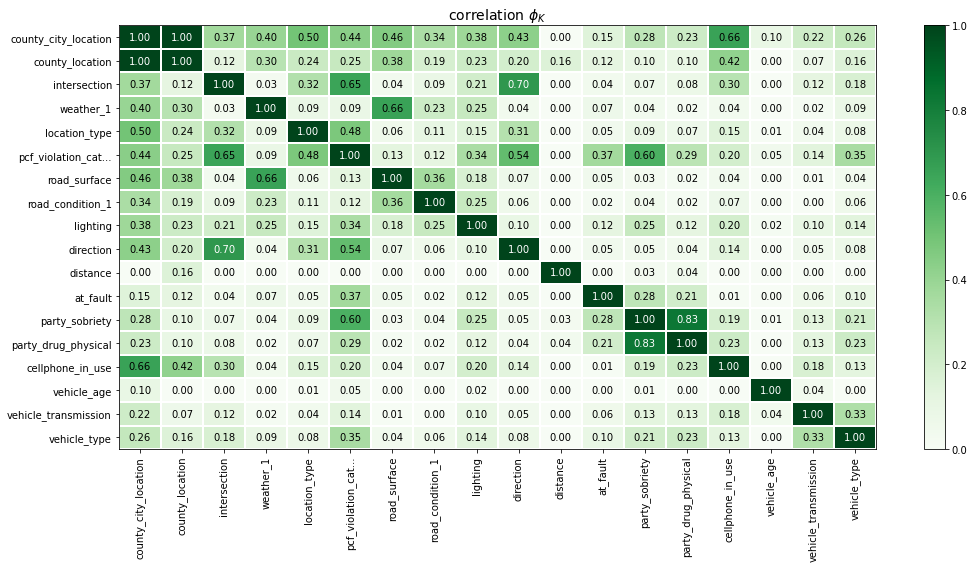

In [42]:
# матрица корреляции
phik_overview = data_unknow.phik_matrix()

plot_correlation_matrix(phik_overview.values.round(2),
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(15, 8))
plt.tight_layout()

In [43]:
# колво объектов классов
height = data_unknow.groupby('at_fault')['at_fault'].count()
height

at_fault
0    26993
1    27916
Name: at_fault, dtype: int64

In [44]:
print('Кол-во объектов 0 в %: ',round(height[0] / (height[0] + height[1]), 2))
print('Кол-во объектов 1 в %: ',round(height[1] / (height[0] + height[1]), 2))

Кол-во объектов 0 в %:  0.49
Кол-во объектов 1 в %:  0.51


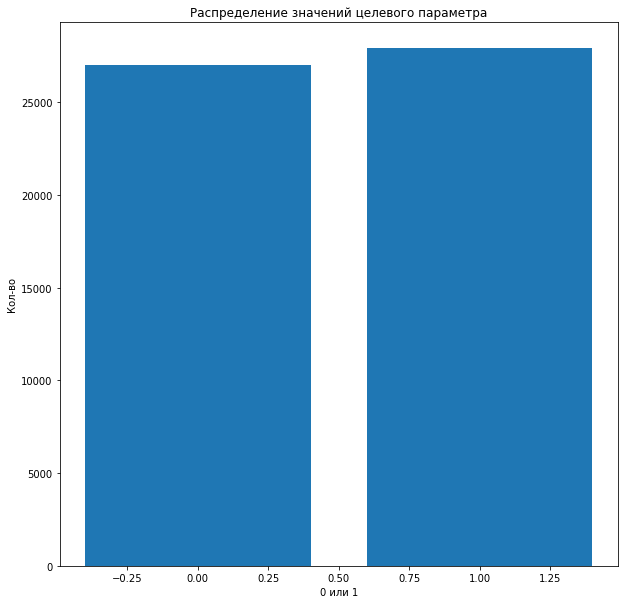

In [45]:
plt.figure(figsize=(10,10))
plt.bar([0, 1] , height)

plt.title(f'Распределение значений целевого параметра')
plt.xlabel('0 или 1')
plt.ylabel('Кол-во')

plt.show()

**Вывод:** Есть небольшой дизбаланс в сторону класса 1. В данном случае кодировки очень большое кол-во пропусков. Между признаками и целевым параметром очень слабая корреляция.

In [46]:
# кодировка через dummy
data_unknow_OHE = data_unknow.copy()

In [47]:
train, test = train_test_split(data_unknow_OHE, test_size = 0.3, random_state = 12345, shuffle = True)

In [48]:
y_train = train['at_fault']
x_train = train.drop('at_fault', axis = 1)

y_test = test['at_fault']
x_test = test.drop('at_fault', axis = 1)


In [49]:
cat_cols

['vehicle_type',
 'vehicle_transmission',
 'party_drug_physical',
 'party_sobriety',
 'direction',
 'lighting',
 'road_condition_1',
 'road_surface',
 'pcf_violation_category',
 'location_type',
 'weather_1',
 'county_location',
 'intersection',
 'cellphone_in_use']

In [50]:
num_col

['vehicle_age', 'distance', 'county_city_location']

In [51]:
x_train.shape, x_test.shape

((38436, 17), (16473, 17))

In [52]:
%%time

# создаем и обучаем encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(x_train[cat_cols])

# трансформируем и обучаем train
x_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train[cat_cols])

# удаляем старые колонки
x_train = x_train.drop(cat_cols, axis=1)

# трансформируем test
x_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_test[cat_cols])

# удаляем старые колонки
x_test = x_test.drop(cat_cols, axis=1)

# # скалируем числовые колонки
scaler = StandardScaler()

x_train[num_col] = scaler.fit_transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: user 5.94 s, sys: 330 ms, total: 6.27 s
Wall time: 12.7 s


Т.к. нам нужно оценить объективность работы нашей модели, мной выбрана метрика roc-auc. Она позволит нам прослеживать склонность модели к ложноположительным срабатываниям и оценить качество модели.

In [53]:
%%time
# модель случайного леса

model_rfc = RandomForestClassifier(random_state = 12345)

# комбинаций гиперпараметров
param_grid = {
    'max_depth': range(5, 16),
    'n_estimators': [150],
    'class_weight': ['None', 'balanced', 'balanced_subsample'], #'None', ],
    'bootstrap':[False, True] #, True],
}

# подбор гиперпараметров
gs_rfc = GridSearchCV(
    model_rfc, 
    param_grid, 
    scoring="roc_auc", 
    n_jobs=-1, 
    cv = 3
)

# фит модели
gs_rfc.fit(x_train, y_train)

print()
print(f'best_score: {gs_rfc.best_score_}')
print()
print(f'best_params: {gs_rfc.best_params_}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
66 fits failed out of a total of 198.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_pa


best_score: 0.7733631365842525

best_params: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 150}
CPU times: user 7min 37s, sys: 1.2 s, total: 7min 38s
Wall time: 15min 42s


In [54]:
%%time
model_CB = CatBoostClassifier(random_state = 12345)

# комбинаций гиперпараметров
param_grid = {
    'learning_rate': [0.1, 0.2],
    'iterations': [100, 250, 500, 1000],
}

# подбор гиперпараметров
gs_CB = GridSearchCV(
    model_CB, 
    param_grid, 
    scoring="roc_auc", 
    n_jobs=-1, 
    cv = 3
)

# фит модели
gs_CB.fit(x_train, y_train)

print()
print(f'best_score: {gs_CB.best_score_}')
print()
print(f'best_params: {gs_CB.best_params_}')

0:	learn: 0.6629391	total: 73.1ms	remaining: 7.24s
1:	learn: 0.6414052	total: 85.3ms	remaining: 4.18s
2:	learn: 0.6242929	total: 96.7ms	remaining: 3.13s
3:	learn: 0.6122002	total: 104ms	remaining: 2.5s
4:	learn: 0.6033418	total: 112ms	remaining: 2.13s
5:	learn: 0.5968058	total: 120ms	remaining: 1.87s
6:	learn: 0.5906383	total: 127ms	remaining: 1.69s
7:	learn: 0.5857019	total: 135ms	remaining: 1.55s
8:	learn: 0.5818072	total: 143ms	remaining: 1.44s
9:	learn: 0.5790640	total: 151ms	remaining: 1.36s
10:	learn: 0.5760014	total: 158ms	remaining: 1.28s
11:	learn: 0.5737711	total: 223ms	remaining: 1.63s
12:	learn: 0.5710825	total: 230ms	remaining: 1.54s
13:	learn: 0.5670984	total: 238ms	remaining: 1.46s
14:	learn: 0.5645647	total: 246ms	remaining: 1.4s
15:	learn: 0.5631958	total: 301ms	remaining: 1.58s
16:	learn: 0.5622780	total: 311ms	remaining: 1.52s
17:	learn: 0.5610518	total: 319ms	remaining: 1.46s
18:	learn: 0.5587975	total: 327ms	remaining: 1.39s
19:	learn: 0.5575811	total: 335ms	remain

In [55]:
# перевод в тензор для нейросети
x_train_n = torch.FloatTensor(x_train.values)
y_train_n = torch.FloatTensor(y_train.values)

x_test_n = torch.FloatTensor(x_test.values)
y_test_n = torch.FloatTensor(y_test.values)

In [57]:
def accuracy_fn(y_true, y_pred):
    '''функция расчета метрики. Для прослеживания динамики обучения'''
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [58]:
%%time
def learn_binary_classification_model(model, n_epochs, print_every_epoch=None):
    
    torch.manual_seed(1234)
    
    '''Функция для обучения нейросети'''
    if print_every_epoch is None:
        print_every_epoch = n_epochs / 10
    
    torch.manual_seed(42)

    for epoch in range(n_epochs):
        ### Обучение
        model.train()

        # 1. Получаем предсказания
        y_logits = model(x_train_n).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) #torch.round(torch.sigmoid(y_logits)) # получаем предсказание (0 или 1)

        # 2. Вычисление функции потерь и точности (accuracy)
        loss = loss_fn(y_logits,
                       y_train_n) 
        acc = accuracy_fn(y_true= y_train_n, 
                          y_pred = y_pred) 

        # 3. Очистка градиентов
        optimizer.zero_grad()

        # 4. Вычисление градиента
        loss.backward()

        # 5. Очередной шаг спуска
        optimizer.step()

        ### Тестирование
        model.eval()
        with torch.inference_mode():
            # 1. Вычисление значений на тесте
            test_logits = model(x_test_n).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Вычисление функции потерь и точности (accuracy)
            test_loss = loss_fn(test_logits,
                                y_test_n)
            test_acc = accuracy_fn(y_true = y_test_n,
                                   y_pred = test_pred)
            
            test_roc_auc = roc_auc_score(y_test_n, test_pred.detach().numpy())
            
        # Выводим статистику каждые 10 итераций
        if epoch % print_every_epoch == 0:
            print(f"Epoch: {epoch:3} | Loss: {loss:.5f}",
                  f"| Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}", 
                  f"| Test acc: {test_acc:.2f}% | Test auc-roc: {test_roc_auc:.2f}")


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [59]:
%%time
# т.к. признаков явно очень много, попробуем отключить часть нейронов
for i in np.arange(0, 0.6, 0.1):
    print('Dropout = ', i)
    model = torch.nn.Sequential(
        torch.nn.Dropout(i),
        torch.nn.Linear(in_features=x_train_n.shape[1], out_features=1),
        torch.nn.Tanh()
    )
    
    # функция потерь
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # оптимизатор
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                lr=0.1)
    
    
    learn_binary_classification_model(model, 700)

Dropout =  0.0
Epoch:   0 | Loss: 0.68837 | Accuracy: 54.21% | Test loss: 0.67227 | Test acc: 59.24% | Test auc-roc: 0.60
Epoch:  70 | Loss: 0.59431 | Accuracy: 69.34% | Test loss: 0.60101 | Test acc: 68.25% | Test auc-roc: 0.68
Epoch: 140 | Loss: 0.59328 | Accuracy: 69.15% | Test loss: 0.59997 | Test acc: 68.03% | Test auc-roc: 0.68
Epoch: 210 | Loss: 0.59285 | Accuracy: 69.15% | Test loss: 0.59957 | Test acc: 67.98% | Test auc-roc: 0.68
Epoch: 280 | Loss: 0.59260 | Accuracy: 69.18% | Test loss: 0.59935 | Test acc: 67.99% | Test auc-roc: 0.68
Epoch: 350 | Loss: 0.59243 | Accuracy: 69.21% | Test loss: 0.59920 | Test acc: 67.99% | Test auc-roc: 0.68
Epoch: 420 | Loss: 0.59231 | Accuracy: 69.22% | Test loss: 0.59910 | Test acc: 67.97% | Test auc-roc: 0.68
Epoch: 490 | Loss: 0.59223 | Accuracy: 69.23% | Test loss: 0.59903 | Test acc: 68.00% | Test auc-roc: 0.68
Epoch: 560 | Loss: 0.59216 | Accuracy: 69.22% | Test loss: 0.59898 | Test acc: 67.98% | Test auc-roc: 0.68
Epoch: 630 | Loss: 0.5

In [60]:
# протестируем сеть без всего

# функция потерь
loss_fn = torch.nn.BCEWithLogitsLoss()
    
# оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

model = torch.nn.Sequential(
    torch.nn.Linear(in_features=x_train_n.shape[1], out_features=1),
    torch.nn.Sigmoid()
    )
learn_binary_classification_model(model, 1000)

Epoch:   0 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 100 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 200 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 300 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 400 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 500 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 600 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 700 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 800 | Loss: 0.72367 | Accuracy: 50.72% | Test loss: 0.72148 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 900 | Loss: 0.72367 | Accuracy

In [61]:
# протестируем сеть с 1 скрытым слоем


# функция потерь
loss_fn = torch.nn.BCEWithLogitsLoss()
    
# оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), 
                                lr=0.1)

model = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(in_features=x_train_n.shape[1], out_features = 16),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features= 16, out_features=1),
    torch.nn.ReLU()
    )
learn_binary_classification_model(model, 1000)

Epoch:   0 | Loss: 0.71185 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 100 | Loss: 0.71181 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 200 | Loss: 0.71180 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 300 | Loss: 0.71183 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 400 | Loss: 0.71184 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 500 | Loss: 0.71186 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 600 | Loss: 0.71188 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 700 | Loss: 0.71183 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 800 | Loss: 0.71185 | Accuracy: 50.72% | Test loss: 0.71016 | Test acc: 51.12% | Test auc-roc: 0.50
Epoch: 900 | Loss: 0.71178 | Accuracy

In [62]:
# протестируем сеть с 2мя скрытыми слоями

# функция потерь
loss_fn = torch.nn.BCEWithLogitsLoss()
    
# оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), 
                                lr=0.1)

model = torch.nn.Sequential(
    torch.nn.Linear(in_features=x_train_n.shape[1], out_features = 16),
    torch.nn.Linear(in_features= 16, out_features=8),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features= 8, out_features=1),
    torch.nn.ReLU()
    )
learn_binary_classification_model(model, 1000)

Epoch:   0 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 100 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 200 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 300 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 400 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 500 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 600 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 700 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 800 | Loss: 0.69313 | Accuracy: 49.28% | Test loss: 0.69315 | Test acc: 48.88% | Test auc-roc: 0.50
Epoch: 900 | Loss: 0.69313 | Accuracy

In [63]:
model = torch.nn.Sequential(
        torch.nn.Dropout(0.1),
        torch.nn.Linear(in_features=x_train_n.shape[1], out_features=1),
        torch.nn.Tanh())
    
# функция потерь
loss_fn = torch.nn.BCEWithLogitsLoss()

# оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

learn_binary_classification_model(model, 1000)

Epoch:   0 | Loss: 0.69431 | Accuracy: 49.85% | Test loss: 0.66179 | Test acc: 60.95% | Test auc-roc: 0.61
Epoch: 100 | Loss: 0.60788 | Accuracy: 66.97% | Test loss: 0.60242 | Test acc: 67.82% | Test auc-roc: 0.68
Epoch: 200 | Loss: 0.60649 | Accuracy: 67.42% | Test loss: 0.60143 | Test acc: 67.75% | Test auc-roc: 0.68
Epoch: 300 | Loss: 0.60735 | Accuracy: 67.21% | Test loss: 0.60167 | Test acc: 67.84% | Test auc-roc: 0.68
Epoch: 400 | Loss: 0.60663 | Accuracy: 67.38% | Test loss: 0.60159 | Test acc: 67.99% | Test auc-roc: 0.68
Epoch: 500 | Loss: 0.60663 | Accuracy: 67.17% | Test loss: 0.60136 | Test acc: 67.84% | Test auc-roc: 0.68
Epoch: 600 | Loss: 0.60781 | Accuracy: 66.72% | Test loss: 0.60135 | Test acc: 67.81% | Test auc-roc: 0.68
Epoch: 700 | Loss: 0.60711 | Accuracy: 67.23% | Test loss: 0.60124 | Test acc: 67.85% | Test auc-roc: 0.68
Epoch: 800 | Loss: 0.60725 | Accuracy: 67.03% | Test loss: 0.60126 | Test acc: 67.81% | Test auc-roc: 0.68
Epoch: 900 | Loss: 0.60687 | Accuracy

In [64]:
# запись результатов обучения нейросети
test_logits = model(x_train_n).squeeze()
test_pred = torch.round(torch.sigmoid(test_logits))
test_roc_auc = roc_auc_score(y_train_n, test_pred.detach().numpy())
print(test_roc_auc)          

0.6891168305614014


In [65]:
best_1 = {'Random_forest': gs_rfc.best_score_, 'CatBoost': gs_CB.best_score_, 'PyTorch_neuro': test_roc_auc}

In [66]:
# результаты моделей
best_1

{'Random_forest': 0.7733631365842525,
 'CatBoost': 0.77965923804746,
 'PyTorch_neuro': 0.6891168305614014}

### Создадим варинат обучения моделей 2. Удалим пропуски.

In [67]:
data_del = big_df_data.copy()

In [68]:
data_del = data_del.drop_duplicates()

In [69]:
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].astype('object')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].replace(1, '1')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].replace(0, '0')
data_unknow['cellphone_in_use'] = data_unknow['cellphone_in_use'].fillna('unknow')

data_unknow['intersection'] = data_unknow['intersection'].astype('object')
data_unknow['intersection'] = data_unknow['intersection'].replace(1, '1')
data_unknow['intersection'] = data_unknow['intersection'].replace(0, '0')
data_unknow['intersection'] = data_unknow['intersection'].fillna('unknow')

In [70]:
data_del.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54909 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_type            54909 non-null  object 
 1   vehicle_transmission    54055 non-null  object 
 2   vehicle_age             53251 non-null  float64
 3   cellphone_in_use        50503 non-null  float64
 4   party_drug_physical     2850 non-null   object 
 5   party_sobriety          54039 non-null  object 
 6   at_fault                54909 non-null  int64  
 7   distance                54909 non-null  float64
 8   direction               42897 non-null  object 
 9   lighting                54755 non-null  object 
 10  road_condition_1        54661 non-null  object 
 11  road_surface            54563 non-null  object 
 12  pcf_violation_category  54148 non-null  object 
 13  location_type           25637 non-null  object 
 14  weather_1               54741 non-null

In [71]:
data_del.isna().sum()

vehicle_type                  0
vehicle_transmission        854
vehicle_age                1658
cellphone_in_use           4406
party_drug_physical       52059
party_sobriety              870
at_fault                      0
distance                      0
direction                 12012
lighting                    154
road_condition_1            248
road_surface                346
pcf_violation_category      761
location_type             29272
weather_1                   168
intersection                174
county_location               0
county_city_location          0
dtype: int64

In [72]:
# данные колонки полностью не заполнены. Исключим их
data_del = data_del.drop('party_drug_physical', axis = 1)
data_del = data_del.drop('location_type', axis = 1)

cat_cols.remove('party_drug_physical')
cat_cols.remove('location_type')

In [73]:
data_del = data_del.dropna()

In [74]:
data_del.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37758 entries, 0 to 56246
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_type            37758 non-null  object 
 1   vehicle_transmission    37758 non-null  object 
 2   vehicle_age             37758 non-null  float64
 3   cellphone_in_use        37758 non-null  float64
 4   party_sobriety          37758 non-null  object 
 5   at_fault                37758 non-null  int64  
 6   distance                37758 non-null  float64
 7   direction               37758 non-null  object 
 8   lighting                37758 non-null  object 
 9   road_condition_1        37758 non-null  object 
 10  road_surface            37758 non-null  object 
 11  pcf_violation_category  37758 non-null  object 
 12  weather_1               37758 non-null  object 
 13  intersection            37758 non-null  float64
 14  county_location         37758 non-null

interval columns not set, guessing: ['vehicle_age', 'cellphone_in_use', 'at_fault', 'distance', 'intersection']


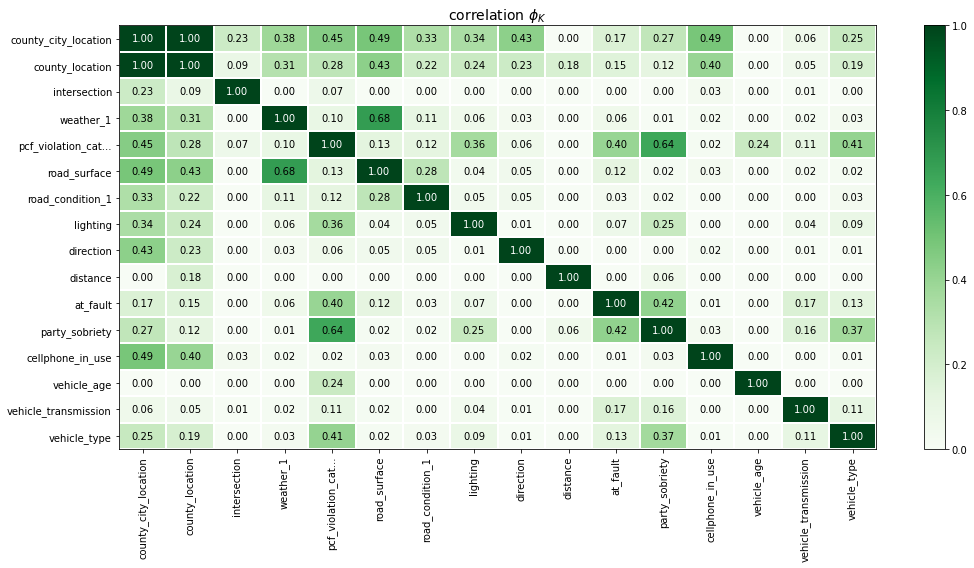

In [75]:
phik_overview = data_del.phik_matrix()

plot_correlation_matrix(phik_overview.values.round(2),
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(15, 8))
plt.tight_layout()

In [76]:
# колво объектов классов
height = data_del.groupby('at_fault')['at_fault'].count()
height

at_fault
0    18224
1    19534
Name: at_fault, dtype: int64

In [77]:
print('Кол-во объектов 0 в %: ',round(height[0] / (height[0] + height[1]), 2))
print('Кол-во объектов 1 в %: ',round(height[1] / (height[0] + height[1]), 2))

Кол-во объектов 0 в %:  0.48
Кол-во объектов 1 в %:  0.52


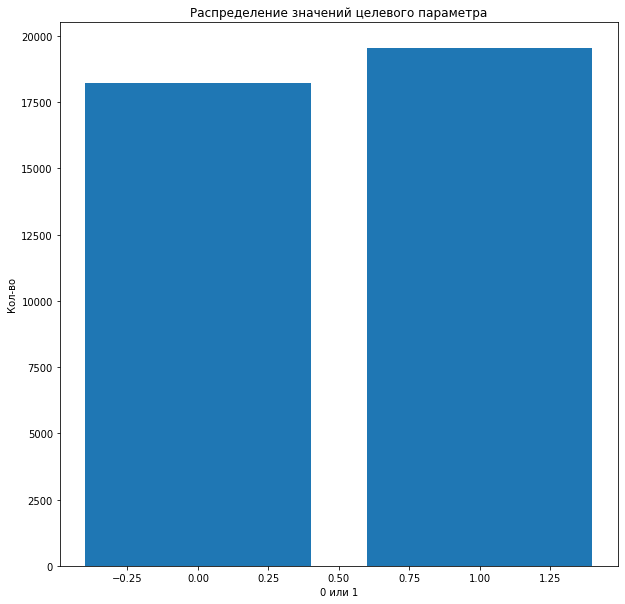

In [78]:
plt.figure(figsize=(10,10))
plt.bar([0, 1] , height)

plt.title(f'Распределение значений целевого параметра')
plt.xlabel('0 или 1')
plt.ylabel('Кол-во')

plt.show()

**Вывод:** При удалении всех пропусков датасет сократился до 39 тыс. строк. Наблюдается так же небольшой дисбаланс классов в сторону 1.

In [79]:
train, test = train_test_split(data_del, test_size = 0.3, random_state = 12345, shuffle = True)

In [80]:
y_train = train['at_fault']
x_train = train.drop('at_fault', axis = 1)

y_test = test['at_fault']
x_test = test.drop('at_fault', axis = 1)

In [81]:
%%time

# создаем и обучаем encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(x_train[cat_cols])

# трансформируем и обучаем train
x_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train[cat_cols])

# удаляем старые колонки
x_train = x_train.drop(cat_cols, axis=1)

# трансформируем test
x_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_test[cat_cols])

# удаляем старые колонки
x_test = x_test.drop(cat_cols, axis=1)

# # скалируем числовые колонки
scaler = StandardScaler()

x_train[num_col] = scaler.fit_transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: user 2.67 s, sys: 53.3 ms, total: 2.72 s
Wall time: 5.5 s


In [82]:
%%time
# модель случайного леса

model_rfc = RandomForestClassifier(random_state = 12345)


# комбинаций гиперпараметров
param_grid = {
    'max_depth': range(5, 16),
    'n_estimators': [150],
    'class_weight': ['None', 'balanced', 'balanced_subsample'], #'None', ],
    'bootstrap':[False, True] #, True],
}

# подбор гиперпараметров
gs_rfc = GridSearchCV(
    model_rfc, 
    param_grid, 
    scoring="roc_auc", 
    n_jobs=-1, 
    cv = 3
)

# фит модели
gs_rfc.fit(x_train, y_train)

print()
print(f'best_score: {gs_rfc.best_score_}')
print()
print(f'best_params: {gs_rfc.best_params_}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
66 fits failed out of a total of 198.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_pa


best_score: 0.7827079144612217

best_params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 150}
CPU times: user 4min 42s, sys: 803 ms, total: 4min 43s
Wall time: 9min 38s


In [83]:
%%time
model_CB = CatBoostClassifier(random_state = 12345)

# комбинаций гиперпараметров
param_grid = {
    'learning_rate': [0.1, 0.2],
    'iterations': [100, 250, 500, 1000]
}

# подбор гиперпараметров
gs_CB = GridSearchCV(
    model_CB, 
    param_grid, 
    scoring="roc_auc", 
    n_jobs=-1, 
    cv = 3
)

# фит модели
gs_CB.fit(x_train, y_train)

print()
print(f'best_score: {gs_CB.best_score_}')
print()
print(f'best_params: {gs_CB.best_params_}')

0:	learn: 0.6577831	total: 9.57ms	remaining: 947ms
1:	learn: 0.6357343	total: 18.1ms	remaining: 889ms
2:	learn: 0.6176881	total: 25.4ms	remaining: 821ms
3:	learn: 0.6030210	total: 31.3ms	remaining: 750ms
4:	learn: 0.5940343	total: 37.1ms	remaining: 705ms
5:	learn: 0.5865008	total: 42.8ms	remaining: 671ms
6:	learn: 0.5810996	total: 48.7ms	remaining: 647ms
7:	learn: 0.5770573	total: 54.7ms	remaining: 629ms
8:	learn: 0.5715871	total: 60.3ms	remaining: 610ms
9:	learn: 0.5690067	total: 66.1ms	remaining: 595ms
10:	learn: 0.5657798	total: 71.9ms	remaining: 582ms
11:	learn: 0.5632754	total: 77.3ms	remaining: 567ms
12:	learn: 0.5596675	total: 82.6ms	remaining: 553ms
13:	learn: 0.5577474	total: 88.1ms	remaining: 541ms
14:	learn: 0.5558634	total: 93.1ms	remaining: 528ms
15:	learn: 0.5541118	total: 146ms	remaining: 768ms
16:	learn: 0.5529734	total: 152ms	remaining: 744ms
17:	learn: 0.5514545	total: 158ms	remaining: 718ms
18:	learn: 0.5505884	total: 163ms	remaining: 697ms
19:	learn: 0.5484168	total

In [84]:
# функция потерь
loss_fn = torch.nn.BCEWithLogitsLoss()
    
# оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), 
                                lr=0.1)


model = torch.nn.Sequential(
        torch.nn.Dropout(0.1),
        torch.nn.Linear(in_features=x_train_n.shape[1], out_features=1),
        torch.nn.Tanh())
    
learn_binary_classification_model(model, 1000)

Epoch:   0 | Loss: 0.69622 | Accuracy: 49.67% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 100 | Loss: 0.69636 | Accuracy: 49.39% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 200 | Loss: 0.69623 | Accuracy: 49.62% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 300 | Loss: 0.69615 | Accuracy: 49.54% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 400 | Loss: 0.69651 | Accuracy: 49.26% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 500 | Loss: 0.69605 | Accuracy: 49.73% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 600 | Loss: 0.69630 | Accuracy: 49.58% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 700 | Loss: 0.69626 | Accuracy: 49.67% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 800 | Loss: 0.69634 | Accuracy: 49.71% | Test loss: 0.69631 | Test acc: 49.34% | Test auc-roc: 0.49
Epoch: 900 | Loss: 0.69630 | Accuracy

In [85]:
logits = model(x_train_n).squeeze() 
pred = torch.round(torch.sigmoid(logits))
loss = loss_fn(logits, y_train_n)
acc = accuracy_fn(y_true = y_train_n, y_pred = pred)
            
roc_auc = roc_auc_score(y_train_n, pred.detach().numpy())

In [86]:
best_2 = {'Random_forest': gs_rfc.best_score_, 'CatBoost': gs_CB.best_score_, 'PyTorch_neuro': roc_auc}

In [87]:
# сравнительная таблица результатов моделей
pd.DataFrame([best_1, best_2], index = ['data_1', 'data_2'])

,Random_forest,CatBoost,PyTorch_neuro
data_1,0.773363,0.779659,0.689117
data_2,0.782708,0.786665,0.495062


**Вывод:** Лучшим вариантиом оказалось заполнение пропусков данных заглушками. Лучашя модель - CatBoost

In [88]:
# Проведем тестирование лучшей модели

train, test = train_test_split(data_del, test_size = 0.3, random_state = 12345, shuffle = True)

y_train = train['at_fault']
x_train = train.drop('at_fault', axis = 1)

y_test = test['at_fault']
x_test = test.drop('at_fault', axis = 1)

In [89]:
%%time

# создаем и обучаем encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(x_train[cat_cols])

# трансформируем и обучаем train
x_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train[cat_cols])

# удаляем старые колонки
x_train = x_train.drop(cat_cols, axis=1)

# трансформируем test
x_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_test[cat_cols])

# удаляем старые колонки
x_test = x_test.drop(cat_cols, axis=1)

# # скалируем числовые колонки
scaler = StandardScaler()

x_train[num_col] = scaler.fit_transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: user 2.69 s, sys: 49.1 ms, total: 2.74 s
Wall time: 5.51 s


In [90]:
%%time
model_best = CatBoostClassifier(learning_rate = 0.1, iterations = 100, random_state = 12345)

model_best.fit(x_train, y_train)

pred = model_best.predict(x_test)

print(roc_auc_score(y_test, pred))

0:	learn: 0.6582962	total: 7.73ms	remaining: 765ms
1:	learn: 0.6350272	total: 26.9ms	remaining: 1.32s
2:	learn: 0.6187349	total: 34.4ms	remaining: 1.11s
3:	learn: 0.6044619	total: 41.9ms	remaining: 1.01s
4:	learn: 0.5943673	total: 49.6ms	remaining: 942ms
5:	learn: 0.5872120	total: 56.8ms	remaining: 889ms
6:	learn: 0.5801754	total: 64.1ms	remaining: 851ms
7:	learn: 0.5742774	total: 119ms	remaining: 1.37s
8:	learn: 0.5700272	total: 127ms	remaining: 1.28s
9:	learn: 0.5647353	total: 134ms	remaining: 1.21s
10:	learn: 0.5622791	total: 142ms	remaining: 1.15s
11:	learn: 0.5598216	total: 149ms	remaining: 1.09s
12:	learn: 0.5566754	total: 157ms	remaining: 1.05s
13:	learn: 0.5547889	total: 164ms	remaining: 1.01s
14:	learn: 0.5537144	total: 172ms	remaining: 974ms
15:	learn: 0.5528189	total: 179ms	remaining: 941ms
16:	learn: 0.5516710	total: 187ms	remaining: 913ms
17:	learn: 0.5495674	total: 195ms	remaining: 887ms
18:	learn: 0.5487659	total: 202ms	remaining: 862ms
19:	learn: 0.5478904	total: 262ms	

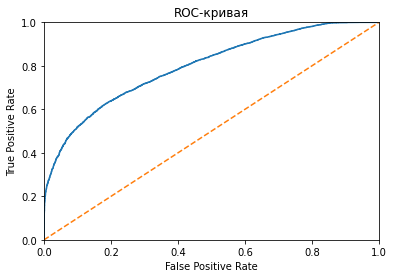

In [91]:
# Построение Roc кривой 

# запись результатов модели при изменении порогов положительного ответа
probabilities_test = model_best.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]


# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()

# построение графика модели
plt.step(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0,1], linestyle = '--')

plt.ylim([0, 1])
plt.xlim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

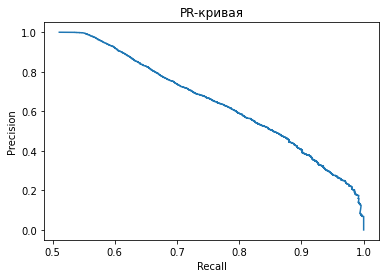

In [92]:
# PR-кривая
probabilities_test = model_best.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = precision_recall_curve(y_test, probabilities_one_test)

plt.figure()

# построение графика модели
plt.step(fpr, tpr)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-кривая")

plt.show()


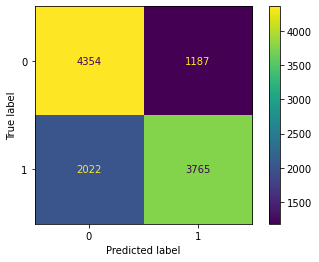

In [93]:
# Матрица ошибок
cm = confusion_matrix(y_test, pred, labels = model_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_best.classes_)

disp.plot()
plt.show()

**Вывод:** Модель склонна давать зачастую ответ 1. Так же видно что она может ошибаться примерно в 1 из 3ёх случаев, больше всего ошибок делает при предсказывании класса 0.

## Проведите анализ важности факторов ДТП

In [94]:
# веса фичей
weights = model_best.get_feature_importance()
feature_weights = pd.DataFrame({'Feature': x_train.columns, 'Weight': weights})
pd.set_option('max_colwidth', 120)
display(feature_weights.sort_values('Weight', ascending = False).head(10))

,Feature,Weight
38,pcf_violation_category_other than driver (or pedestrian),23.330640
8,party_sobriety_had not been drinking,21.825026
29,pcf_violation_category_dui,8.919294
34,pcf_violation_category_improper turning,8.461548
7,"party_sobriety_had been drinking, under influence",8.390670
4,vehicle_type_sedan,5.849162
0,vehicle_age,5.269652
43,pcf_violation_category_unknown,4.261855
1,distance,2.204283
40,pcf_violation_category_pedestrian violation,2.183717


In [95]:
# изучим топ 1 фичу по весу
big_df_data.groupby('pcf_violation_category')['vehicle_type'].count().sort_values(ascending = False)

pcf_violation_category
speeding                             18241
improper turning                      8191
automobile right of way               7142
dui                                   6222
unsafe lane change                    4667
traffic signals and signs             3375
unsafe starting or backing            1380
wrong side of road                    1377
other than driver (or pedestrian)     1149
following too closely                 1015
unknown                                911
other hazardous violation              517
improper passing                       478
pedestrian violation                   314
other improper driving                 226
pedestrian right of way                112
other equipment                         84
impeding traffic                        33
hazardous parking                       32
brakes                                  10
lights                                   3
fell asleep                              3
Name: vehicle_type, dtype: int6

In [96]:
height = big_df_data.loc[big_df_data['pcf_violation_category'] == 'other than driver (or pedestrian)'] \
    .groupby('at_fault')['at_fault'].count()
height

at_fault
0    1149
Name: at_fault, dtype: int64

Все строчки данных с данной категорией принадлежат классу 0. Поэтому не целесообразно изучать данный признак т.к. модель просто заучила ответ. Возьмем следующий признак

In [97]:
height = big_df_data.loc[big_df_data['party_sobriety'] == 'had not been drinking'] \
    .groupby('at_fault')['at_fault'].count()
height

at_fault
0    26824
1    21753
Name: at_fault, dtype: int64

In [98]:
big_df_data.groupby('party_sobriety')['vehicle_type'].count().sort_values(ascending = False)

party_sobriety
had not been drinking                     48577
had been drinking, under influence         4475
impairment unknown                         1238
had been drinking, not under influence      575
had been drinking, impairment unknown       261
not applicable                              250
Name: vehicle_type, dtype: int64

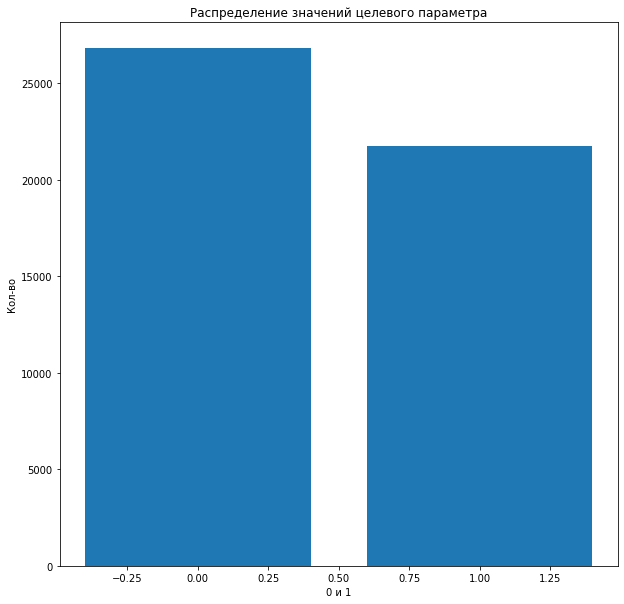

In [99]:
plt.figure(figsize=(10,10))
plt.bar([0, 1] , height)

plt.title(f'Распределение значений целевого параметра')
plt.xlabel('0 и 1')
plt.ylabel('Кол-во')

plt.show()

**Вывод:** Самым значимым фактором модель выбрала состояние водителя, а именно отсутствие алкогольного опьянения. Вероятно стоит рассмотреть возможность оценивать уровень алкоголя перед выдачей автомобиля.

## Выводы

<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">
<h1>Итог:</h1>

>В ходе работы были выполнены следующие операции:
>>- Изучена общая информация о ДТП
>>- Сформированн датасет для обучения моделей
>>- Подготовлены данные для обучения моделей 
>>- Исследованы лучшие результаты разных моделей
>>- Выбрана лучшая модель
>>- Исследовано качество модели  
>>- Исследованы веса классов

> В ходе исследования была выявлена самая лучшая модель для предсказания возможного ДТП - CatBoost. Результат тестовой выборки составляет 0.65. Модель не сильно превосходит случайное угадывание, всего на 15%, поэтому она лишь немного переходит порог адекватности, так же присутствует переобучение. Сказывается отсутствие факторов, которые могли бы корелировать с целевой переменной. Рекомендую добавить информацию о водительском стаже, износе тормозов и шин. В данном с
